In [1]:
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
import scipy
import os
import seaborn as sns
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import gc
from scipy.stats import pearsonr
import os
import scanpy as sc
import muon as mu
from scipy.sparse import issparse, csr_matrix
from typing import Optional
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.sparse import issparse
from scipy.spatial import distance_matrix
import warnings

warnings.filterwarnings("ignore")

gc.enable()

/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/in68/miniconda3/envs/cell2loc_env/lib/python3.9/site-pac

In [2]:
from utility_scripts import *

## Databases: 

In [3]:
#Load and process the gene annotation file to use metadata for analysis e.g. Biotype % calculations
# Read the .tsv file
gtf_info = pd.read_csv("Annotation_files/GRCm39_GENCODEM32_ReoT1L_gene_info_gtf.tsv", sep="\t")
gtf_info = gtf_info.drop_duplicates(subset=['GENEID'], keep='first')

# Remove period/decimal suffixes from ensembl IDs
gtf_info['GeneID'] = gtf_info['GENEID'].str.split('.').str[0]

# Extract chromosome value before the colon
gtf_info['chr'] = gtf_info['Chromosome'].str.split(':').str[0]

# Add '.1' to the Reovirus gene names to match the gtf file...
gtf_info["GENEID"] = [f"{GENE}.1" if 'T1LReovirus' in GENE else GENE for GENE in gtf_info['GENEID']]

print(f"Using {len(gtf_info['GENEID'].unique())} ensembl IDs, from {gtf_info['GeneSymbol'].nunique()} genes, and {gtf_info['Biotype'].nunique()} biotypes...\n")

# Display the first few rows
print(gtf_info.head())



#Add NCBI taxonomic ID file as dataframe to build taxonomic-level specific adata objects 
taxid = pd.read_csv('Annotation_files/ncbi_lineages_2024-01-19.csv')
Taxonomic_df = taxid.copy()
def add_prefix(x):
    return f'taxid_{x}'

# Applying function to 'tax_id' column
Taxonomic_df['tax_id'] = Taxonomic_df['tax_id'].apply(add_prefix)

# Display the updated DataFrame
print(Taxonomic_df.head())

Using 56973 ensembl IDs, from 56825 genes, and 38 biotypes...

                 GENEID     GeneSymbol            Chromosome  \
0  ENSMUSG00000102693.2  4933401J01Rik  chr1:3143476-3144545   
1  ENSMUSG00000064842.3        Gm26206  chr1:3172239-3172348   
2  ENSMUSG00000051951.6           Xkr4  chr1:3276124-3741721   
3  ENSMUSG00000102851.2        Gm18956  chr1:3322980-3323459   
4  ENSMUSG00000103377.2        Gm37180  chr1:3435954-3438772   

                Biotype Strand              GeneID   chr  
0                   TEC      +  ENSMUSG00000102693  chr1  
1                 snRNA      +  ENSMUSG00000064842  chr1  
2        protein_coding      -  ENSMUSG00000051951  chr1  
3  processed_pseudogene      +  ENSMUSG00000102851  chr1  
4                   TEC      -  ENSMUSG00000103377  chr1  
    tax_id superkingdom          phylum                class  \
0  taxid_1          NaN             NaN                  NaN   
1  taxid_2     Bacteria             NaN                  NaN   
2  tax

In [4]:
taxid_to_delete = ['taxid_1', 'taxid_10090', 'taxid_119060', 'taxid_1211813', 'taxid_1224',
       'taxid_1236', 'taxid_1239', 'taxid_1268', 'taxid_1269', 'taxid_1279',
       'taxid_1280', 'taxid_1301', 'taxid_131567', 'taxid_1351', 'taxid_1385',
       'taxid_1396', 'taxid_1491', 'taxid_153135', 'taxid_1624',
       'taxid_165779', 'taxid_1716', 'taxid_1745854', 'taxid_1747',
       'taxid_1760', 'taxid_1783272', 'taxid_1789224', 'taxid_1853699',
       'taxid_186817', 'taxid_1883', 'taxid_190721', 'taxid_1912216',
       'taxid_191302', 'taxid_1916956', 'taxid_2', 'taxid_201174',
       'taxid_2049881', 'taxid_2184519', 'taxid_2306583', 'taxid_2618356',
       'taxid_2654547', 'taxid_2712222', 'taxid_2722752', 'taxid_2726118',
       'taxid_2782662', 'taxid_28211', 'taxid_28216', 'taxid_286',
       'taxid_2862880', 'taxid_2892442', 'taxid_2986923', 'taxid_2986930',
       'taxid_314146', 'taxid_31957', 'taxid_31989', 'taxid_32207',
       'taxid_33011', 'taxid_33958', 'taxid_358', 'taxid_36845', 'taxid_40324',
       'taxid_42906', 'taxid_43675', 'taxid_44283', 'taxid_446469',
       'taxid_465541', 'taxid_469', 'taxid_471', 'taxid_48736', 'taxid_524884',
       'taxid_525919', 'taxid_543', 'taxid_55601', 'taxid_564137', 'taxid_570',
       'taxid_573', 'taxid_59732', 'taxid_80840', 'taxid_82541', 'taxid_85006',
       'taxid_881', 'taxid_91061', 'taxid_91347', 'taxid_93386', 'taxid_9606',
       'taxid_976']

In [15]:
# Load the taxonomic identifiers for bacteria from a DataFrame
bacteria_taxids = Taxonomic_df[Taxonomic_df['superkingdom'] == 'Bacteria']['tax_id']
viruses_taxids = Taxonomic_df[Taxonomic_df['superkingdom'] == 'Viruses']['tax_id']
archaea_taxids = Taxonomic_df[Taxonomic_df['superkingdom'] == 'Archaea']['tax_id']

# Define the base directory where the host and microbial data are stored
base_dir = "/workdir/in68/microSTRS/subsampling/"
spatial_coord_path = "/workdir/lt425/202403_visium/visium-v1_coordinates.txt"
# List all the sample identifiers
samples = [f"STRS_B_{fraction}" for fraction in ['0.1', '0.25', '0.5', '0.75', '1.0']] + \
          [f"STRS_D_{fraction}" for fraction in ['0.1', '0.25', '0.5', '0.75', '1.0']] + \
          [f"Visium_B_{fraction}" for fraction in ['0.1', '0.25', '0.5', '0.75', '1.0']] + \
          [f"Visium_D_{fraction}" for fraction in ['0.1', '0.25', '0.5', '0.75', '1.0']]
mudata_dict = {}

# Process data for each sample
for sample in samples:
    try:
        # Assemble the directory path for the host data for the current sample
        host_data_dir = os.path.join(base_dir, f"Sample_{sample}_solo/Solo.out/GeneFull/raw/")

        
        # Check if the host data directory exists; skip the sample if it doesn't
        if not os.path.exists(host_data_dir):
            print(f"Host data directory does not exist: {host_data_dir}")
            continue

        # Read the host gene expression data using the 10x Genomics format
        adata_host = sc.read_10x_mtx(host_data_dir, var_names='gene_symbols')
        adata_host = normalize_spatial_coordinates(adata_host, spatial_coord_path)
        adata_host.raw = adata_host.copy()
        # Add biotypes percentage and total counts to the host data
        add_biotypes_pct(adata_host, gtf_info)
        adata_host.obs['Total_counts'] = adata_host.X.sum(axis=1)
        
        
        # Construct the path for microbial data and verify it
        microbial_data_path = os.path.join(base_dir, f"Sample_{sample}_solo/microbe.h5ad")
        
        # Check if the microbial data file exists; skip the sample if it doesn't
        if not os.path.exists(microbial_data_path):
            print(f"Microbial data file does not exist: {microbial_data_path}")
            continue

        # Read the microbial data
        adata_unmapped = sc.read_h5ad(microbial_data_path)
        adata_unmapped = normalize_spatial_coordinates(adata_unmapped, spatial_coord_path)

        # Store the raw microbial data
        adata_unmapped.raw = adata_unmapped.copy()
        taxonomy_tmp = Taxonomic_df.copy()
        adata_unmapped.obs['Total_counts_unfiltered'] = adata_unmapped.X.sum(axis=1)

        # Filter the microbial data to include only bacteria
        mask = adata_unmapped.var.index.isin(bacteria_taxids)
        adata_bacteria = adata_unmapped[:, mask].copy()
        adata_bacteria.obs['Total_counts_unfiltered'] = adata_bacteria.X.sum(axis=1)

        # Delete the taxids that are found in controls
        mask2 = adata_bacteria.var.index.isin(taxid_to_delete)
        adata_bacteria = adata_bacteria[:, ~mask2].copy()


        
        # Filter the microbial data to include only virus
        mask = adata_unmapped.var.index.isin(viruses_taxids)
        adata_virus = adata_unmapped[:, mask].copy()
        adata_virus.obs['Total_counts_unfiltered'] = adata_virus.X.sum(axis=1)

        # Delete the taxids that are found in controls from virus
        mask2 = adata_virus.var.index.isin(taxid_to_delete)
        adata_virus = adata_virus[:, ~mask2].copy()
        adata_virus.obs['Total_counts'] = adata_virus.X.sum(axis=1)


        
        # Filter the microbial data to include only ARCHAEA
        mask = adata_unmapped.var.index.isin(archaea_taxids)
        adata_archaea = adata_unmapped[:, mask].copy()
        adata_archaea.obs['Total_counts_unfiltered'] = adata_archaea.X.sum(axis=1)

        # Delete the taxids that are found in controls from virus
        mask2 = adata_archaea.var.index.isin(taxid_to_delete)
        adata_archaea = adata_archaea[:, ~mask2].copy()
        adata_archaea.obs['Total_counts'] = adata_archaea.X.sum(axis=1)


        
        adata_host.obs['Total_molecules_detected'] = adata_host.obs['Total_counts'] + adata_unmapped.obs['Total_counts_unfiltered']
        adatas = {'host': adata_host, 'bacteria': adata_bacteria.copy(),
                  'viruses': adata_virus.copy(),'archaea': adata_archaea.copy(), 
                  'unmapped_all': adata_unmapped.copy()}



        
        # Process each taxonomic level bacteria
        for tax_level in ['species', 'genus', 'family', 'phylum']:
            # adata_bacteria.uns['taxonomy'][tax_level] = adata_ba el].fillna('unclassified')
            tax_id_to_name = dict(zip(Taxonomic_df['tax_id'], Taxonomic_df[tax_level]))
            adata_bacteria.var[tax_level] = adata_bacteria.var.index.map(tax_id_to_name).fillna('unclassified')
            adata_df = pd.DataFrame(adata_bacteria.X.toarray(), columns=adata_bacteria.var[tax_level])
            aggregated_data = adata_df.groupby(adata_df.columns, axis=1).sum()

            new_vars = pd.DataFrame(index=aggregated_data.columns)
            X_mat = csr_matrix(np.round(aggregated_data.values).astype(np.float32))

            new_adata_bacteria = sc.AnnData(X=X_mat, var=new_vars, obs=adata_bacteria.obs)

            # Add the raw component
            new_adata_bacteria.raw = new_adata_bacteria.copy()

            new_adata_bacteria.obs['Total_counts'] = new_adata_bacteria.X.sum(axis=1)
            unclassified_mask = new_adata_bacteria.var.index == 'unclassified'
            new_adata_bacteria.obs['Total_counts_unclassified'] = new_adata_bacteria[:, unclassified_mask].X.sum(axis=1)
            new_adata_bacteria.obs['Total_counts_classified'] = new_adata_bacteria.obs['Total_counts'] - new_adata_bacteria.obs['Total_counts_unclassified']
            # Filtering step after calculating Total_counts
            # total_counts = new_adata_bacteria.obs['Total_counts'].sum()
            # taxon_percentages = new_adata_bacteria.X.sum(axis=0) / total_counts * 100

            # # Identify taxa that are <= 0.01% and remove them
            # low_abundance_mask = taxon_percentages <= 0.01
            # new_adata_bacteria = new_adata_bacteria[:, ~low_abundance_mask].copy()
            # # Remove 'unclassified' variable if it exists
            # if 'unclassified' in new_adata_bacteria.var_names:
            #     unclassified_mask = new_adata_bacteria.var_names == 'unclassified'
            #     new_adata_bacteria = new_adata_bacteria[:, ~unclassified_mask].copy()


            
            # Normalize counts and log transform
            total_microbial_counts = new_adata_bacteria.X.sum()
            new_adata_bacteria.X = new_adata_bacteria.X / total_microbial_counts * 10000
            new_adata_bacteria = normalize_spatial_coordinates(new_adata_bacteria, spatial_coord_path)
            spot_counts = new_adata_bacteria.X > 0
            unique_genes_per_spot = spot_counts.sum(axis=1)
            new_adata_bacteria.obs['unique_taxa_per_spot'] = unique_genes_per_spot
            sc.pp.log1p(new_adata_bacteria)

            adatas[tax_level] = new_adata_bacteria
            # Delete intermediate variables to free up memory
            del adata_df, aggregated_data, new_vars, X_mat, new_adata_bacteria, tax_id_to_name
       

        # Process each taxonomic level for virus
        for tax_level in ['species', 'genus', 'family', 'phylum']:
            # adata_virus.uns['taxonomy'][tax_level] = adata_virus.uns['taxonomy'][tax_level].fillna('unclassified')
            tax_id_to_name = dict(zip(Taxonomic_df['tax_id'], Taxonomic_df[tax_level]))
            adata_virus.var[tax_level] = adata_virus.var.index.map(tax_id_to_name).fillna('unclassified')
            adata_df = pd.DataFrame(adata_virus.X.toarray(), columns=adata_virus.var[tax_level])
            aggregated_data = adata_df.groupby(adata_df.columns, axis=1).sum()

            new_vars = pd.DataFrame(index=aggregated_data.columns)
            X_mat = csr_matrix(np.round(aggregated_data.values).astype(np.float32))

            new_adata_virus = sc.AnnData(X=X_mat, var=new_vars, obs=adata_virus.obs)

            # Add the raw component
            new_adata_virus.raw = new_adata_virus.copy()

            new_adata_virus.obs['Total_counts'] = new_adata_virus.X.sum(axis=1)
            unclassified_mask = new_adata_virus.var.index == 'unclassified'
            new_adata_virus.obs['Total_counts_unclassified'] = new_adata_virus[:, unclassified_mask].X.sum(axis=1)
            new_adata_virus.obs['Total_counts_classified'] = new_adata_virus.obs['Total_counts'] - new_adata_virus.obs['Total_counts_unclassified']

            # Normalize counts and log transform
            total_microbial_counts = new_adata_virus.X.sum()
            new_adata_virus.X = new_adata_virus.X / total_microbial_counts * 10000
            new_adata_virus = normalize_spatial_coordinates(new_adata_virus, spatial_coord_path)
            spot_counts = new_adata_virus.X > 0
            unique_genes_per_spot = spot_counts.sum(axis=1)
            new_adata_virus.obs['unique_taxa_per_spot'] = unique_genes_per_spot
            sc.pp.log1p(new_adata_virus)
            tax_level_to_use = f"{tax_level}_virus"
            adatas[tax_level_to_use] = new_adata_virus
            # Delete intermediate variables to free up memory
            del adata_df, aggregated_data, new_vars, X_mat, new_adata_virus, tax_id_to_name
            
        # Process each taxonomic level for archaea
        for tax_level in ['species', 'genus', 'family', 'phylum']:
            # adata_archaea.uns['taxonomy'][tax_level] = adata_archaea.uns['taxonomy'][tax_level].fillna('unclassified')
            tax_id_to_name = dict(zip(Taxonomic_df['tax_id'], Taxonomic_df[tax_level]))
            adata_archaea.var[tax_level] = adata_archaea.var.index.map(tax_id_to_name).fillna('unclassified')
            adata_df = pd.DataFrame(adata_archaea.X.toarray(), columns=adata_archaea.var[tax_level])
            aggregated_data = adata_df.groupby(adata_df.columns, axis=1).sum()

            new_vars = pd.DataFrame(index=aggregated_data.columns)
            X_mat = csr_matrix(np.round(aggregated_data.values).astype(np.float32))

            new_adata_archaea = sc.AnnData(X=X_mat, var=new_vars, obs=adata_archaea.obs)

            # Add the raw component
            new_adata_archaea.raw = new_adata_archaea.copy()

            new_adata_archaea.obs['Total_counts'] = new_adata_archaea.X.sum(axis=1)
            unclassified_mask = new_adata_archaea.var.index == 'unclassified'
            new_adata_archaea.obs['Total_counts_unclassified'] = new_adata_archaea[:, unclassified_mask].X.sum(axis=1)
            new_adata_archaea.obs['Total_counts_classified'] = new_adata_archaea.obs['Total_counts'] - new_adata_archaea.obs['Total_counts_unclassified']

            # Normalize counts and log transform
            total_microbial_counts = new_adata_archaea.X.sum()
            new_adata_archaea.X = new_adata_archaea.X / total_microbial_counts * 10000
            new_adata_archaea = normalize_spatial_coordinates(new_adata_archaea, spatial_coord_path)
            spot_counts = new_adata_archaea.X > 0
            unique_genes_per_spot = spot_counts.sum(axis=1)
            new_adata_archaea.obs['unique_taxa_per_spot'] = unique_genes_per_spot
            sc.pp.log1p(new_adata_archaea)
            tax_level_to_use = f"{tax_level}_archaea"
            adatas[tax_level_to_use] = new_adata_archaea



            
            # Delete intermediate variables to free up memory
            del adata_df, aggregated_data, new_vars, X_mat, new_adata_archaea, tax_id_to_name

        # Store the combined data object for each sample
        mudata_dict[sample] = mu.MuData(adatas)

        # Delete intermediate variables to free up memory
        del adata_host, adata_unmapped, adata_bacteria, adatas, mask, mask2

    except Exception as e:
        print(f"An error occurred while processing sample {sample}: {e}")

# Output which samples have been successfully processed
print("Processed samples:", list(mudata_dict.keys()))
gc.collect()


Added spatial coordinates for 4992 cells.
No gene_version1 genes found...
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4942 cells.
Added spatial coordinates for 4992 cells.
No gene_version1 genes found...
Added spatial coordinates for 4980 cells.
Added spatial coordinates for 4980 cells.
Added spatial coordinates for 4980 cells.
Added spatial coordinates for 4980 cells.
Added spatial coordinates for 4980 cells.
Added spatial coordinates for 4980 cells.
Added spatial coordinates for 4980 cells.
Added spatia

16110

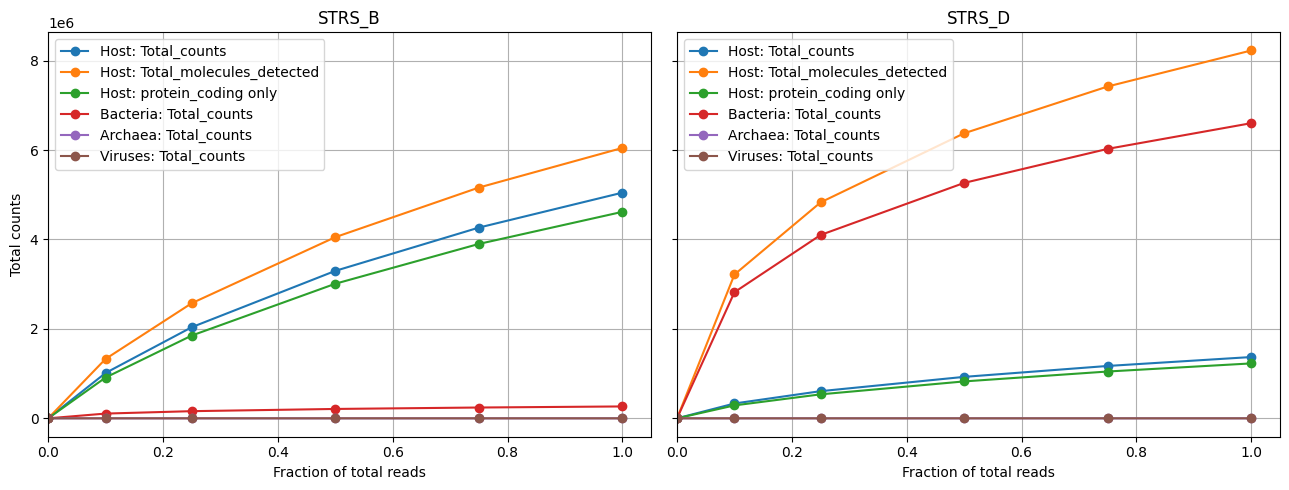

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define sample prefixes and increasing fractions
prefixes = ["STRS_B", "STRS_D"]
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]

# Get protein-coding gene list from gtf_info
protein_coding_genes = gtf_info.loc[gtf_info["Biotype"] == "protein_coding", "GeneSymbol"].unique().tolist()

# Set up the figure
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

for i, prefix in enumerate(prefixes):
    total_counts_host = [0]
    total_mols_host = [0]
    total_counts_pc = [0]
    total_counts_bact = [0]
    total_counts_arch = [0]
    total_counts_virus = [0]
    frac_values = [0.0]

    for frac in fractions:
        key = f"{prefix}_{frac}"
        md = mudata_dict[key]
        host = md.mod["host"]

        frac_values.append(frac)
        total_counts_host.append(host.obs["Total_counts"].sum())
        total_mols_host.append(host.obs["Total_molecules_detected"].sum())

        pc_genes = [g for g in protein_coding_genes if g in host.var_names]
        total_counts_pc.append(host[:, pc_genes].X.sum())

        total_counts_bact.append(md.mod["bacteria"].obs["Total_counts_unfiltered"].sum())
        total_counts_arch.append(md.mod["archaea"].obs["Total_counts_unfiltered"].sum())
        total_counts_virus.append(md.mod["viruses"].obs["Total_counts_unfiltered"].sum())

    ax = axes[i]
    ax.plot(frac_values, total_counts_host, label="Host: Total_counts", marker='o')
    ax.plot(frac_values, total_mols_host, label="Host: Total_molecules_detected", marker='o')
    ax.plot(frac_values, total_counts_pc, label="Host: protein_coding only", marker='o')
    ax.plot(frac_values, total_counts_bact, label="Bacteria: Total_counts", marker='o')
    ax.plot(frac_values, total_counts_arch, label="Archaea: Total_counts", marker='o')
    ax.plot(frac_values, total_counts_virus, label="Viruses: Total_counts", marker='o')

    ax.set_title(prefix)
    ax.set_xlabel("Fraction of total reads")
    ax.set_xlim(0, 1.05)
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Total counts")
plt.tight_layout()
plt.show()


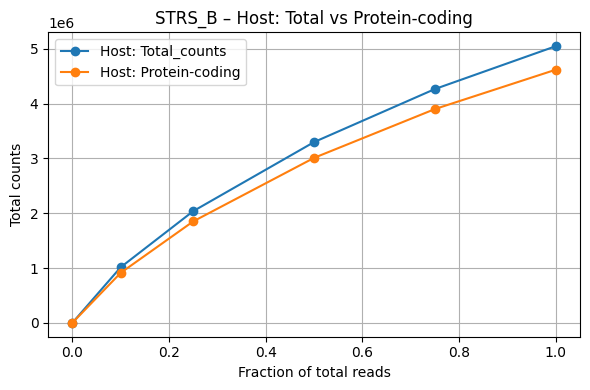

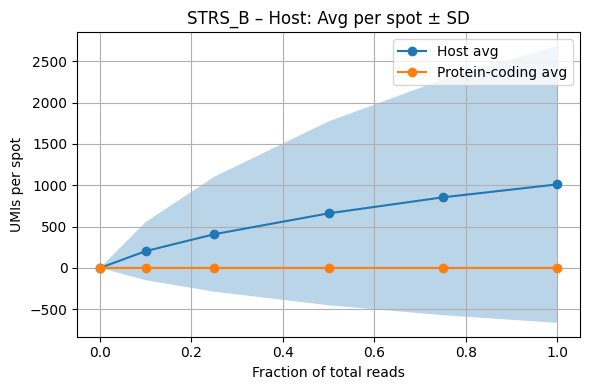

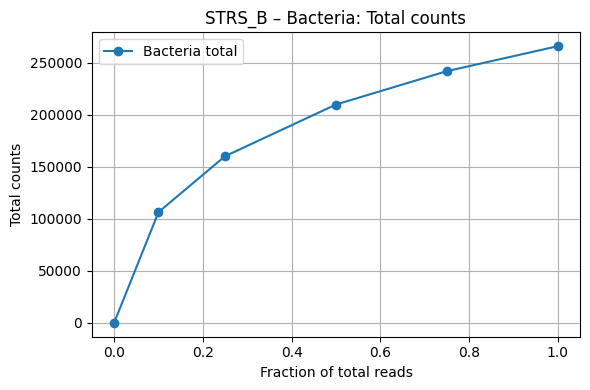

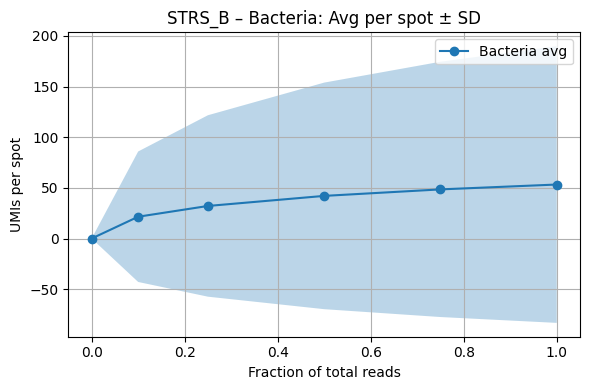

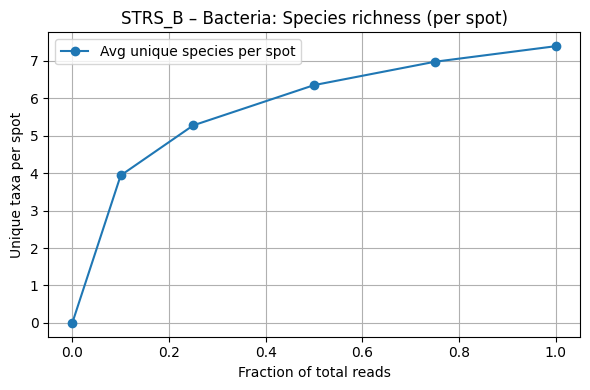

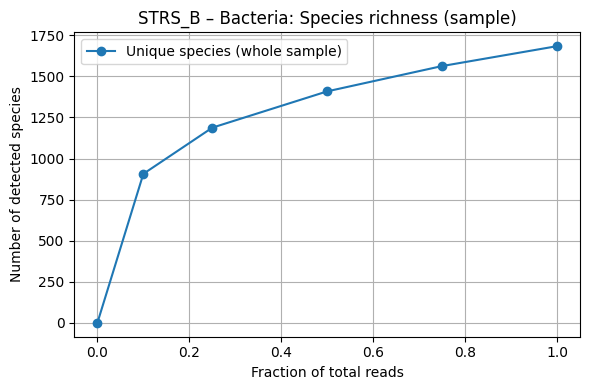

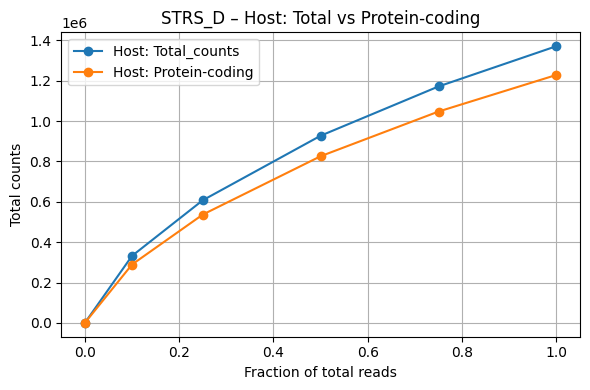

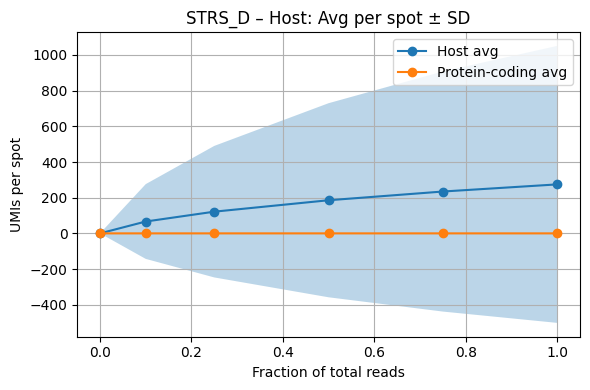

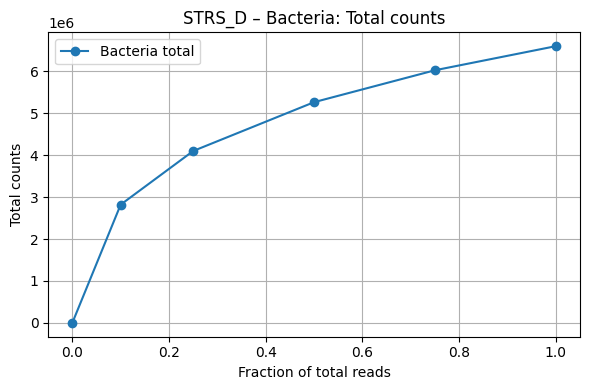

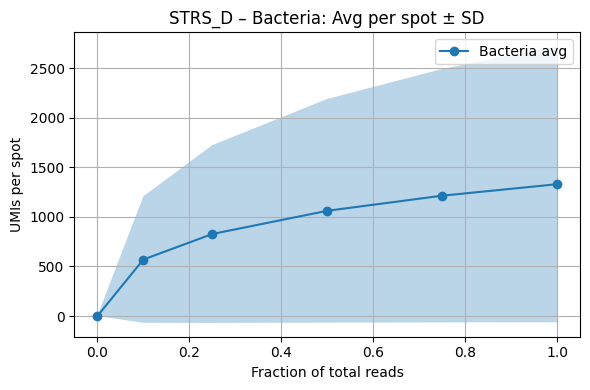

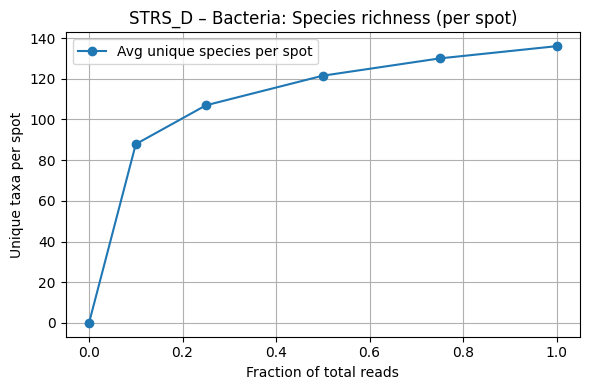

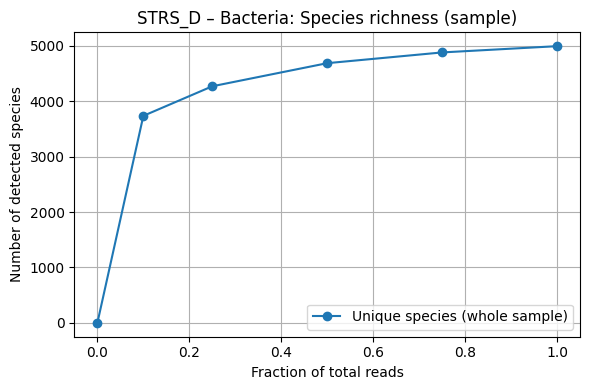

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

prefixes = ["STRS_B", "STRS_D","Visium_B", "Visium_D"]
fractions = [0.1, 0.25, 0.5, 0.75, 1.0]

protein_coding_genes = gtf_info.loc[gtf_info["Biotype"] == "protein_coding", "GeneSymbol"].unique().tolist()

for prefix in prefixes:
    total_host = [0]
    total_pc = [0]
    avg_host = [0]
    avg_pc = [0]
    std_host = [0]
    std_pc = [0]

    total_bacteria = [0]
    avg_bacteria = [0]
    std_bacteria = [0]
    unique_species = [0]
    unique_species_sample = [0]  # NEW — species richness per sample

    frac_values = [0.0]

    for frac in fractions:
        key = f"{prefix}_{frac}"
        md = mudata_dict[key]
        host = md.mod["host"]
        bacteria = md.mod["bacteria"]
        species = md.mod["species"]

        frac_values.append(frac)

        # host total and protein coding only
        total_host.append(host.obs["Total_counts"].sum())
        pc_genes = [g for g in protein_coding_genes if g in host.var_names]
        total_pc.append(host[:, pc_genes].X.sum())

        avg_host.append(host.obs["Total_counts"].mean())
        std_host.append(host.obs["Total_counts"].std())
        avg_pc.append(host[:, pc_genes].X.toarray().mean())
        std_pc.append(host[:, pc_genes].X.toarray().std())

        # bacteria
        total_bacteria.append(bacteria.obs["Total_counts_unfiltered"].sum())
        avg_bacteria.append(bacteria.obs["Total_counts_unfiltered"].mean())
        std_bacteria.append(bacteria.obs["Total_counts_unfiltered"].std())

        # per-spot species richness
        unique_species.append(species.obs["unique_taxa_per_spot"].mean())

        # total richness across the sample
        total_unique_species = (species.X.sum(axis=0) > 0).sum()
        if hasattr(total_unique_species, "A1"):
            total_unique_species = total_unique_species.A1[0]
        unique_species_sample.append(total_unique_species)

    # convert to np arrays
    frac_np = np.array(frac_values)
    avg_host = np.array(avg_host)
    std_host = np.array(std_host)
    avg_pc = np.array(avg_pc)
    std_pc = np.array(std_pc)
    avg_bacteria = np.array(avg_bacteria)
    std_bacteria = np.array(std_bacteria)

    # PLOT 1
    plt.figure(figsize=(6, 4))
    plt.plot(frac_np, total_host, label="Host: Total_counts", marker='o')
    plt.plot(frac_np, total_pc, label="Host: Protein-coding", marker='o')
    plt.title(f"{prefix} – Host: Total vs Protein-coding")
    plt.xlabel("Fraction of total reads")
    plt.ylabel("Total counts")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PLOT 2
    plt.figure(figsize=(6, 4))
    plt.plot(frac_np, avg_host, label="Host avg", marker='o')
    plt.fill_between(frac_np, avg_host - std_host, avg_host + std_host, alpha=0.3)
    plt.plot(frac_np, avg_pc, label="Protein-coding avg", marker='o')
    plt.fill_between(frac_np, avg_pc - std_pc, avg_pc + std_pc, alpha=0.3)
    plt.title(f"{prefix} – Host: Avg per spot ± SD")
    plt.xlabel("Fraction of total reads")
    plt.ylabel("UMIs per spot")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PLOT 3
    plt.figure(figsize=(6, 4))
    plt.plot(frac_np, total_bacteria, label="Bacteria total", marker='o')
    plt.title(f"{prefix} – Bacteria: Total counts")
    plt.xlabel("Fraction of total reads")
    plt.ylabel("Total counts")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PLOT 4
    plt.figure(figsize=(6, 4))
    plt.plot(frac_np, avg_bacteria, label="Bacteria avg", marker='o')
    plt.fill_between(frac_np, avg_bacteria - std_bacteria, avg_bacteria + std_bacteria, alpha=0.3)
    plt.title(f"{prefix} – Bacteria: Avg per spot ± SD")
    plt.xlabel("Fraction of total reads")
    plt.ylabel("UMIs per spot")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PLOT 5
    plt.figure(figsize=(6, 4))
    plt.plot(frac_np, unique_species, label="Avg unique species per spot", marker='o')
    plt.title(f"{prefix} – Bacteria: Species richness (per spot)")
    plt.xlabel("Fraction of total reads")
    plt.ylabel("Unique taxa per spot")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # PLOT 6
    plt.figure(figsize=(6, 4))
    plt.plot(frac_np, unique_species_sample, label="Unique species (whole sample)", marker='o')
    plt.title(f"{prefix} – Bacteria: Species richness (sample)")
    plt.xlabel("Fraction of total reads")
    plt.ylabel("Number of detected species")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


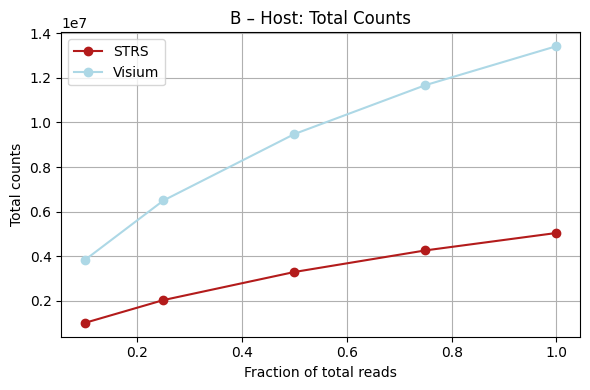

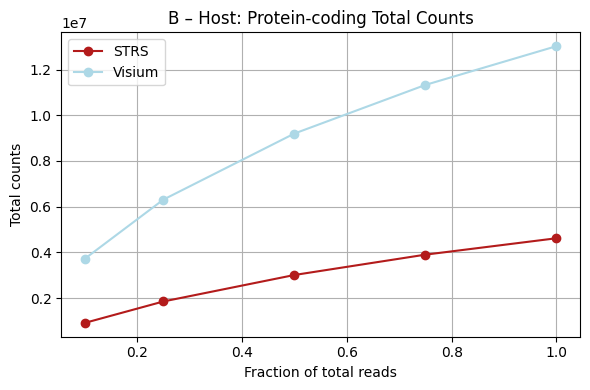

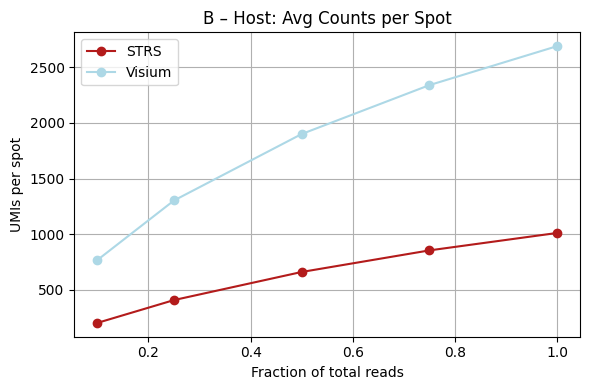

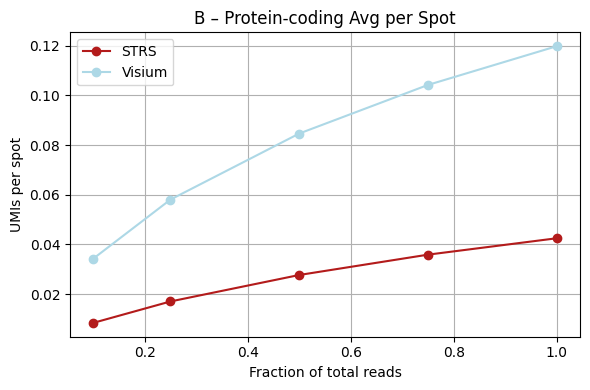

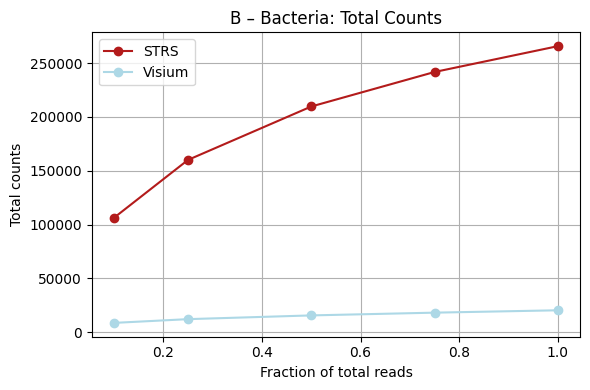

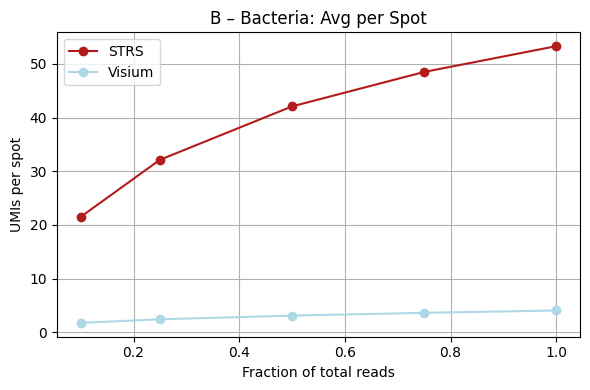

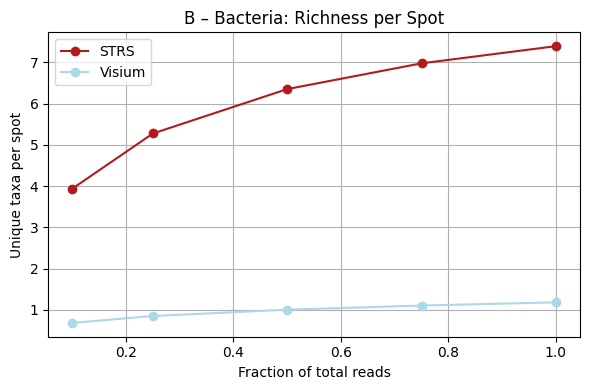

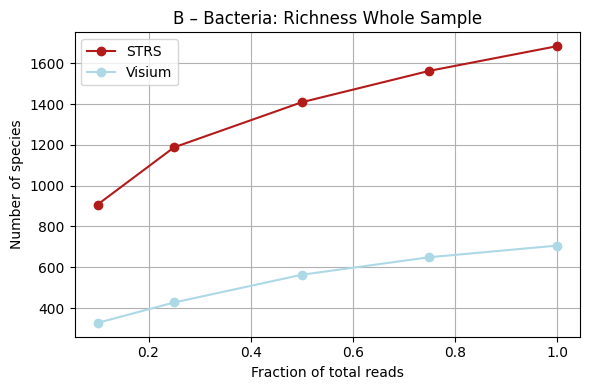

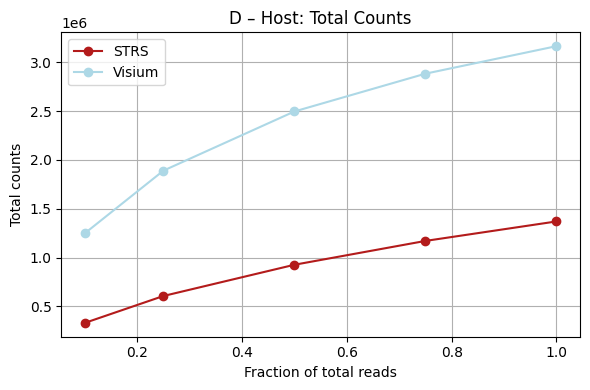

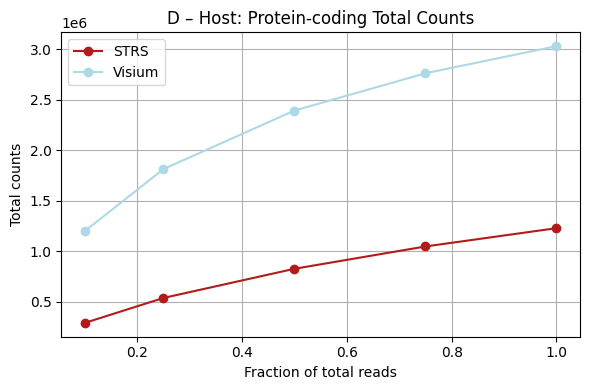

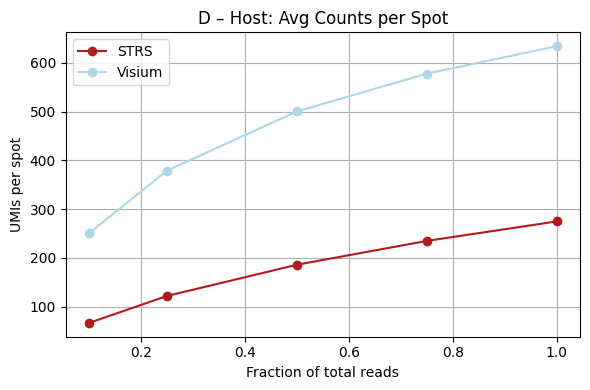

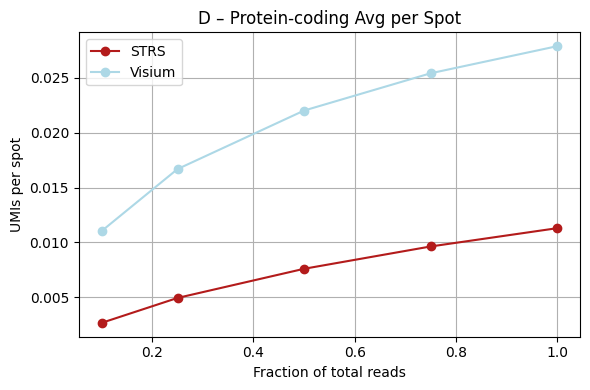

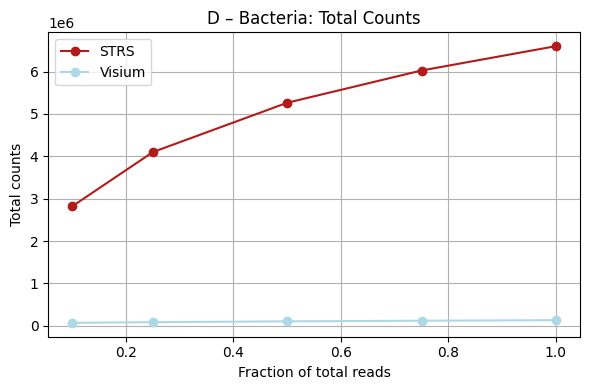

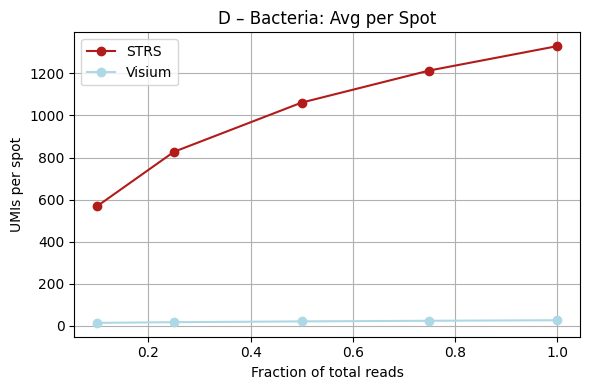

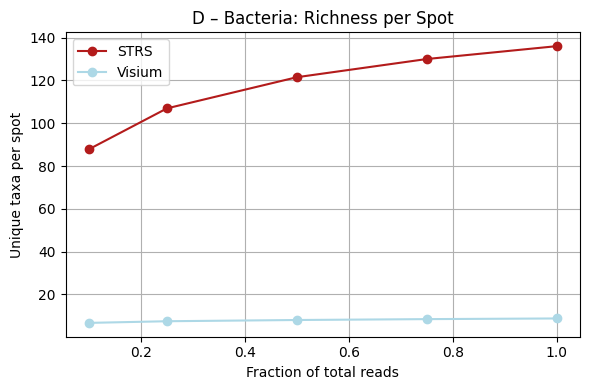

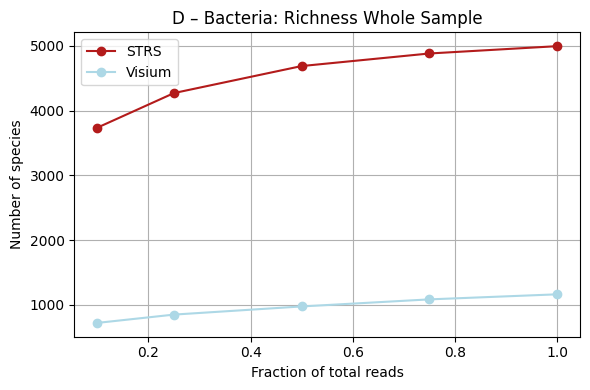

In [16]:
import matplotlib.pyplot as plt
import numpy as np
# Define list of protein-coding gene symbols
protein_coding_genes = gtf_info.loc[gtf_info["Biotype"] == "protein_coding", "GeneSymbol"].unique().tolist()

fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
samples = ["B", "D"]
platforms = {"STRS": "#B31B1B", "Visium": "#ADD8E6"}

metric_data = {
    "total_host": {}, "total_pc": {},
    "avg_host": {}, "avg_pc": {},
    "total_bacteria": {}, "avg_bacteria": {},
    "unique_species": {}, "unique_species_sample": {}
}

for sample in samples:
    for platform in platforms:
        prefix = f"{platform}_{sample}"
        key = f"{sample}_{platform}"
        
        total_host, total_pc = [], []
        avg_host, avg_pc = [], []
        total_bacteria, avg_bacteria = [], []
        unique_species, unique_species_sample = [], []

        for frac in fractions:
            fkey = f"{prefix}_{frac}"
            if fkey not in mudata_dict:
                print(f"Missing: {fkey}")
                total_host.append(np.nan)
                total_pc.append(np.nan)
                avg_host.append(np.nan)
                avg_pc.append(np.nan)
                total_bacteria.append(np.nan)
                avg_bacteria.append(np.nan)
                unique_species.append(np.nan)
                unique_species_sample.append(np.nan)
                continue

            md = mudata_dict[fkey]
            host = md.mod["host"]
            bacteria = md.mod["bacteria"]
            species = md.mod["species"]
            pc_genes = [g for g in protein_coding_genes if g in host.var_names]
            host_X = host[:, pc_genes].X.toarray() if hasattr(host[:, pc_genes].X, 'toarray') else host[:, pc_genes].X

            total_host.append(host.obs["Total_counts"].sum())
            total_pc.append(host_X.sum())
            avg_host.append(host.obs["Total_counts"].mean())
            avg_pc.append(host_X.mean())
            total_bacteria.append(bacteria.obs["Total_counts_unfiltered"].sum())
            avg_bacteria.append(bacteria.obs["Total_counts_unfiltered"].mean())
            unique_species.append(species.obs["unique_taxa_per_spot"].mean())

            total_unique_species = (species.X.sum(axis=0) > 0).sum()
            if hasattr(total_unique_species, "A1"):
                total_unique_species = total_unique_species.A1[0]
            unique_species_sample.append(total_unique_species)

        metric_data["total_host"][key] = total_host
        metric_data["total_pc"][key] = total_pc
        metric_data["avg_host"][key] = avg_host
        metric_data["avg_pc"][key] = avg_pc
        metric_data["total_bacteria"][key] = total_bacteria
        metric_data["avg_bacteria"][key] = avg_bacteria
        metric_data["unique_species"][key] = unique_species
        metric_data["unique_species_sample"][key] = unique_species_sample

# --- PLOTTING ---

for sample in samples:
    for metric, ylabel, title in [
        ("total_host", "Total counts", "Host: Total Counts"),
        ("total_pc", "Total counts", "Host: Protein-coding Total Counts"),
        ("avg_host", "UMIs per spot", "Host: Avg Counts per Spot"),
        ("avg_pc", "UMIs per spot", "Protein-coding Avg per Spot"),
        ("total_bacteria", "Total counts", "Bacteria: Total Counts"),
        ("avg_bacteria", "UMIs per spot", "Bacteria: Avg per Spot"),
        ("unique_species", "Unique taxa per spot", "Bacteria: Richness per Spot"),
        ("unique_species_sample", "Number of species", "Bacteria: Richness Whole Sample")
    ]:
        plt.figure(figsize=(6, 4))
        for platform, color in platforms.items():
            key = f"{sample}_{platform}"
            yvals = metric_data[metric][key]
            plt.plot(fractions, yvals, label=platform, color=color, marker='o')
        plt.title(f"{sample} – {title}")
        plt.xlabel("Fraction of total reads")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


🔎 Fetching read counts...
✅ Loaded read counts for 20 samples

🧮 Calculating metrics from mudata_dict...
✅ Metric collection complete

📊 Plotting saturation curves...


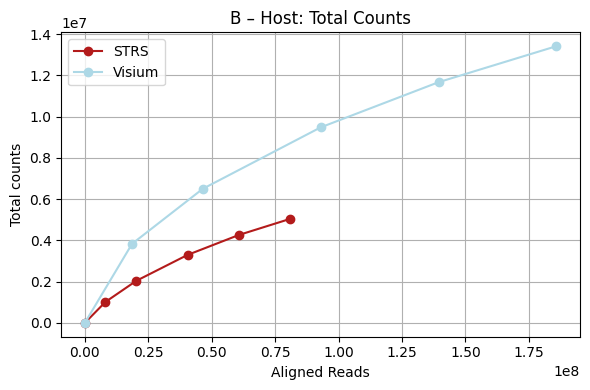

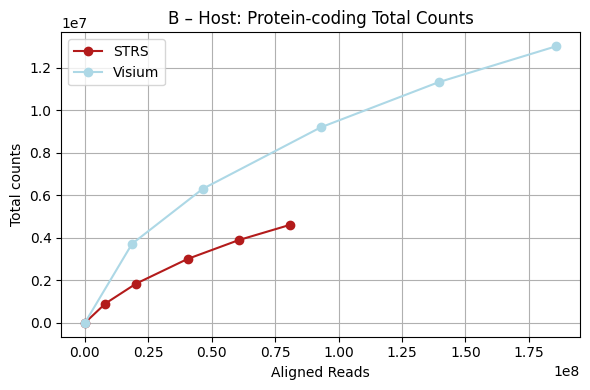

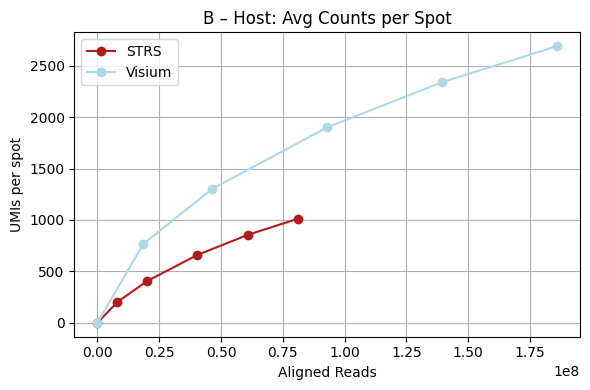

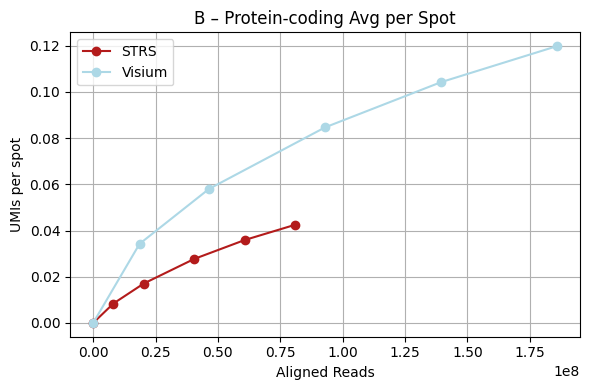

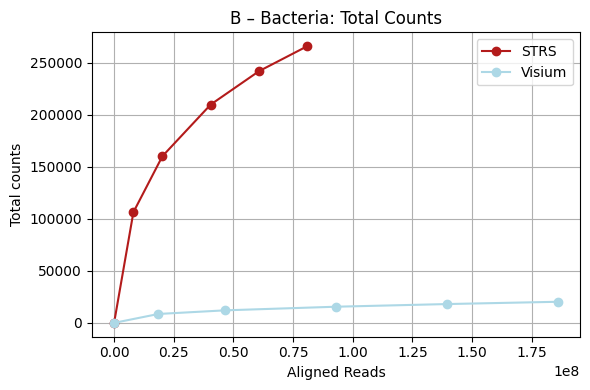

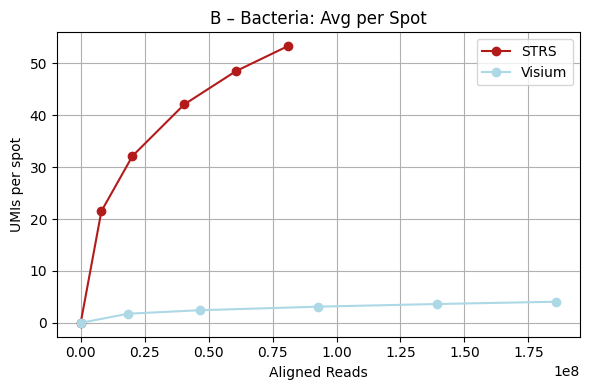

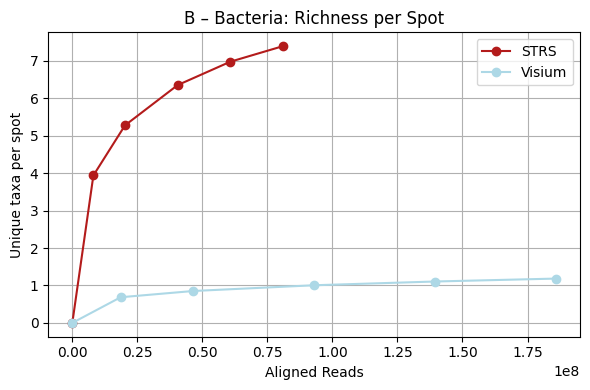

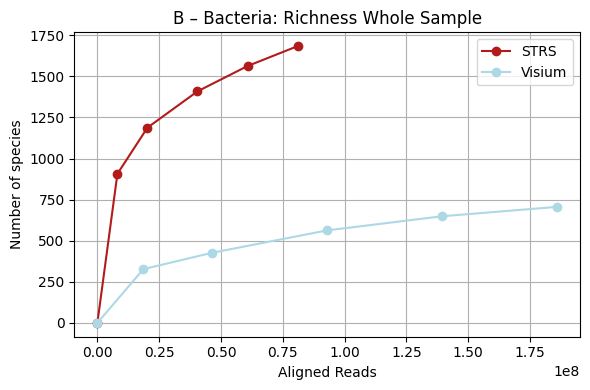

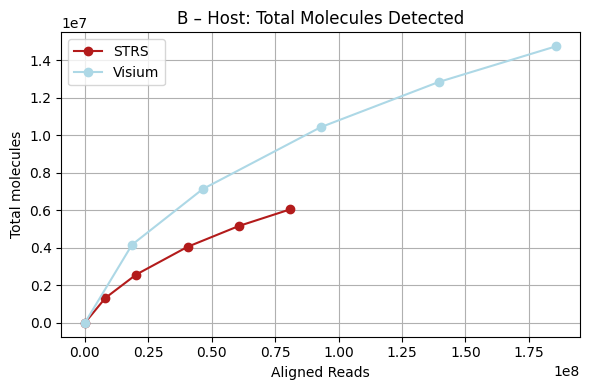

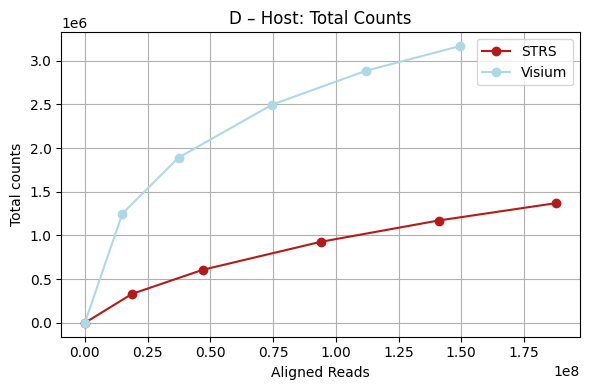

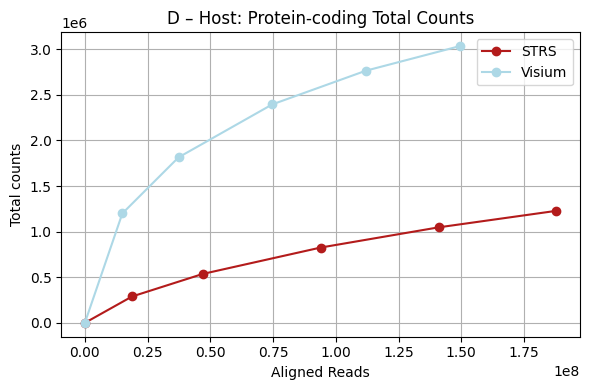

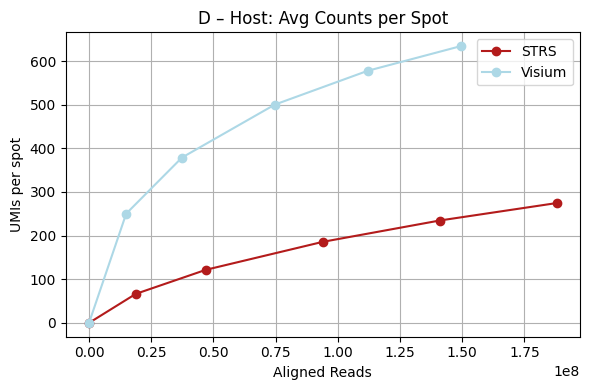

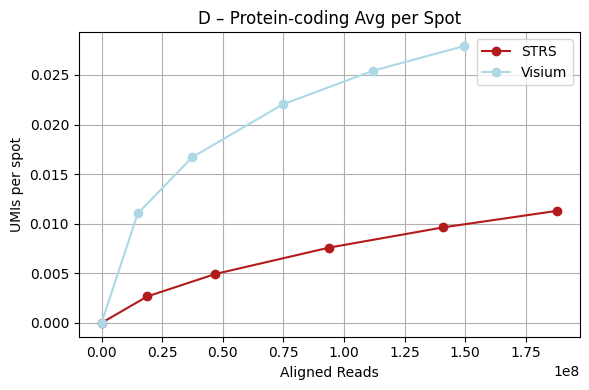

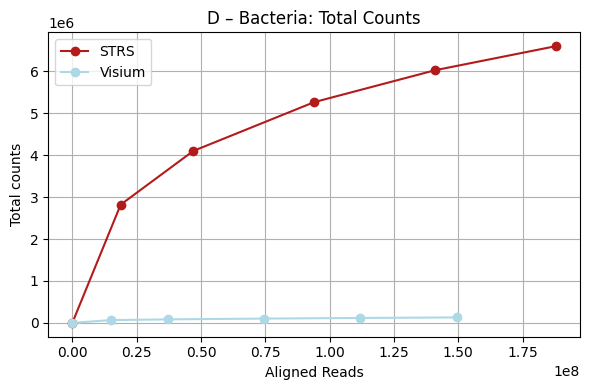

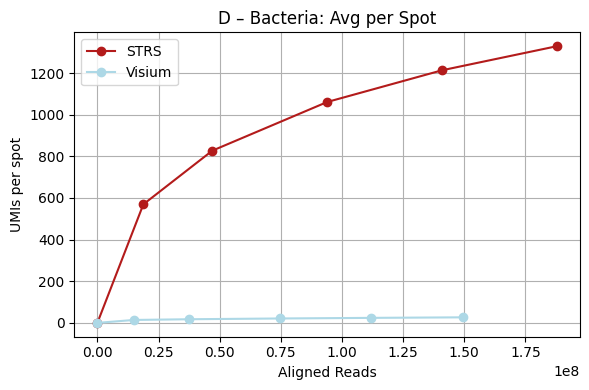

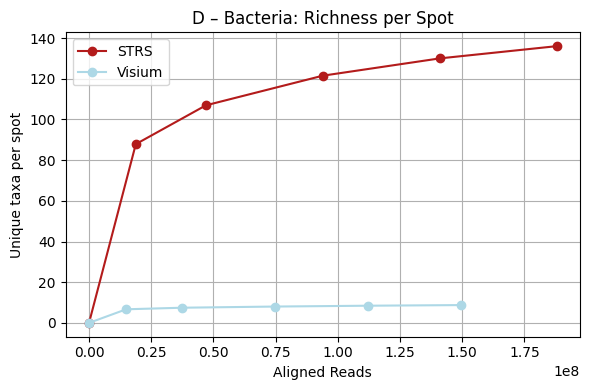

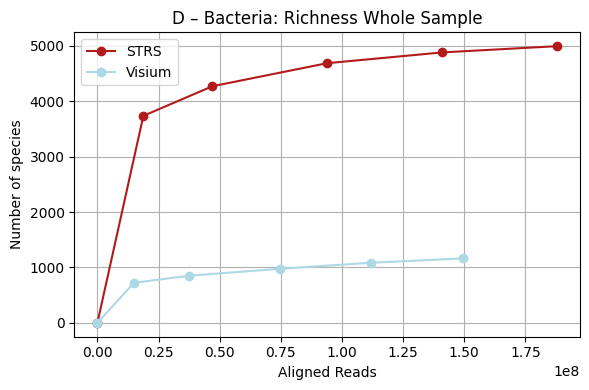

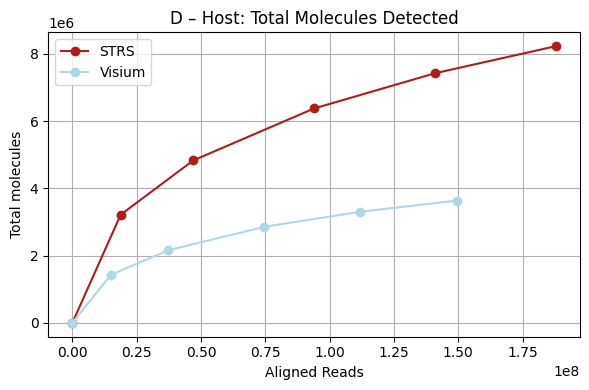


🧪 Fitting Michaelis-Menten to 'total_molecules_detected'...

📈 B_STRS: Vmax = 10751985.26, Km = 64673835.95


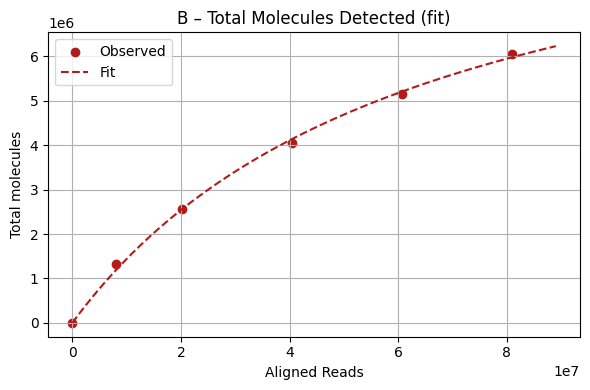

📈 B_Visium: Vmax = 21636419.95, Km = 93109398.49


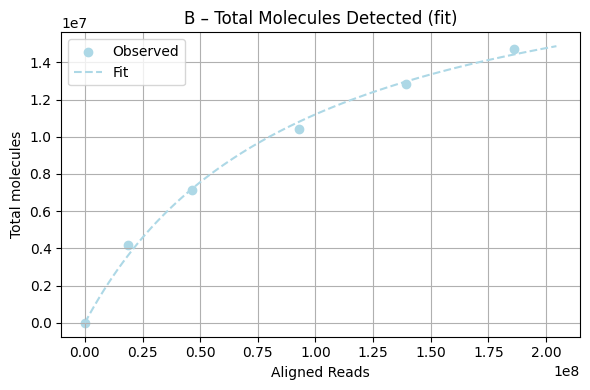

📈 D_STRS: Vmax = 9930867.90, Km = 46354728.71


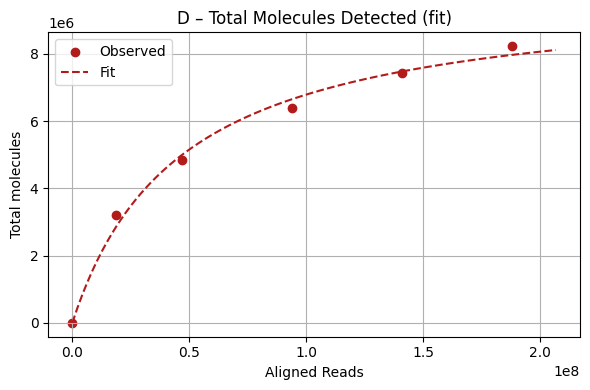

📈 D_Visium: Vmax = 4388266.72, Km = 36009007.70


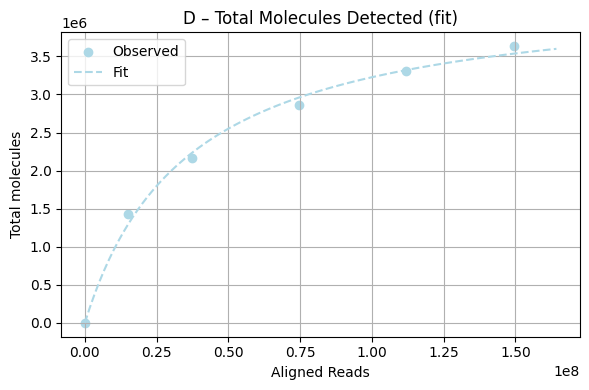

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# -------------------- STEP 1: Load Read Counts -------------------- #

fractions_str = ['0.1', '0.25', '0.5', '0.75', '1.0']
platforms = ["STRS", "Visium"]
sides = ["B", "D"]

samples = [f"{platform}_{side}_{frac}" for platform in platforms for side in sides for frac in fractions_str]
base_dir = "/workdir/in68/microSTRS/subsampling/"
reads_summary = {}

print("🔎 Fetching read counts...")
for sample in samples:
    summary_file_path = os.path.join(base_dir, f"Sample_{sample}_solo/Solo.out/GeneFull/Summary.csv")
    if os.path.exists(summary_file_path):
        try:
            df = pd.read_csv(summary_file_path, header=None)
            df = df.T
            df.columns = df.iloc[0]
            df = df.drop(df.index[0])
            if "Number of Reads" in df.columns:
                value = pd.to_numeric(df["Number of Reads"].values[0], errors='coerce')
                reads_summary[sample] = float(value)
            else:
                print(f"[WARN] Column 'Number of Reads' not found in {sample}")
        except Exception as e:
            print(f"[ERROR] Failed to parse Summary.csv for {sample}: {e}")
    else:
        print(f"[MISSING FILE] {summary_file_path}")

# Final read count lookup
read_count_lookup = {k: v for k, v in reads_summary.items() if pd.notna(v)}
print(f"✅ Loaded read counts for {len(read_count_lookup)} samples\n")

# -------------------- STEP 2: Compute Metrics -------------------- #

print("🧮 Calculating metrics from mudata_dict...")
protein_coding_genes = gtf_info.loc[gtf_info["Biotype"] == "protein_coding", "GeneSymbol"].unique().tolist()
platform_colors = {"STRS": "#B31B1B", "Visium": "#ADD8E6"}

metric_data = {
    "total_host": {}, "total_pc": {},
    "avg_host": {}, "avg_pc": {},
    "total_bacteria": {}, "avg_bacteria": {},
    "unique_species": {}, "unique_species_sample": {},
    "total_molecules_detected": {}
}

for sample in sides:
    for platform in platforms:
        key = f"{sample}_{platform}"
        total_host, total_pc = [], []
        avg_host, avg_pc = [], []
        total_bacteria, avg_bacteria = [], []
        unique_species, unique_species_sample = [], []
        total_molecules_detected = []

        for frac in fractions_str:
            fkey = f"{platform}_{sample}_{frac}"
            if fkey not in mudata_dict:
                print(f"[SKIP] Missing mudata_dict for: {fkey}")
                total_host.append(np.nan)
                total_pc.append(np.nan)
                avg_host.append(np.nan)
                avg_pc.append(np.nan)
                total_bacteria.append(np.nan)
                avg_bacteria.append(np.nan)
                unique_species.append(np.nan)
                unique_species_sample.append(np.nan)
                total_molecules_detected.append(np.nan)
                continue

            md = mudata_dict[fkey]
            host = md.mod["host"]
            bacteria = md.mod["bacteria"]
            species = md.mod["species"]

            pc_genes = [g for g in protein_coding_genes if g in host.var_names]
            host_X = host[:, pc_genes].X.toarray() if hasattr(host[:, pc_genes].X, 'toarray') else host[:, pc_genes].X

            total_host.append(host.obs["Total_counts"].sum())
            total_pc.append(host_X.sum())
            avg_host.append(host.obs["Total_counts"].mean())
            avg_pc.append(host_X.mean())
            total_bacteria.append(bacteria.obs["Total_counts_unfiltered"].sum())
            avg_bacteria.append(bacteria.obs["Total_counts_unfiltered"].mean())
            unique_species.append(species.obs["unique_taxa_per_spot"].mean())

            total_unique_species = (species.X.sum(axis=0) > 0).sum()
            if hasattr(total_unique_species, "A1"):
                total_unique_species = total_unique_species.A1[0]
            unique_species_sample.append(total_unique_species)

            # NEW: Total molecules detected
            if "Total_molecules_detected" in host.obs.columns:
                total_mol = host.obs["Total_molecules_detected"].sum()
            else:
                print(f"[WARN] Missing 'Total_molecules_detected' in {fkey}")
                total_mol = np.nan
            total_molecules_detected.append(total_mol)

        metric_data["total_host"][key] = total_host
        metric_data["total_pc"][key] = total_pc
        metric_data["avg_host"][key] = avg_host
        metric_data["avg_pc"][key] = avg_pc
        metric_data["total_bacteria"][key] = total_bacteria
        metric_data["avg_bacteria"][key] = avg_bacteria
        metric_data["unique_species"][key] = unique_species
        metric_data["unique_species_sample"][key] = unique_species_sample
        metric_data["total_molecules_detected"][key] = total_molecules_detected

print("✅ Metric collection complete\n")

# -------------------- STEP 3: Plot Saturation Curves -------------------- #

print("📊 Plotting saturation curves...")
for sample in sides:
    for metric, ylabel, title in [
        ("total_host", "Total counts", "Host: Total Counts"),
        ("total_pc", "Total counts", "Host: Protein-coding Total Counts"),
        ("avg_host", "UMIs per spot", "Host: Avg Counts per Spot"),
        ("avg_pc", "UMIs per spot", "Protein-coding Avg per Spot"),
        ("total_bacteria", "Total counts", "Bacteria: Total Counts"),
        ("avg_bacteria", "UMIs per spot", "Bacteria: Avg per Spot"),
        ("unique_species", "Unique taxa per spot", "Bacteria: Richness per Spot"),
        ("unique_species_sample", "Number of species", "Bacteria: Richness Whole Sample"),
        ("total_molecules_detected", "Total molecules", "Host: Total Molecules Detected")
    ]:
        plt.figure(figsize=(6, 4))
        plotted = False

        for platform in platforms:
            mkey = f"{sample}_{platform}"
            yvals = metric_data[metric].get(mkey, [])
            snames = [f"{platform}_{sample}_{frac}" for frac in fractions_str]

            xvals_clean = []
            yvals_clean = []

            for i, sname in enumerate(snames):
                rc = read_count_lookup.get(sname, np.nan)
                yval = yvals[i] if i < len(yvals) else np.nan
                if not np.isnan(rc) and not np.isnan(yval):
                    xvals_clean.append(rc)
                    yvals_clean.append(yval)

            # Add (0, 0) anchor
            xvals_clean.insert(0, 0)
            yvals_clean.insert(0, 0)

            if len(xvals_clean) < 2:
                print(f"[SKIP] No valid data for {mkey} / {metric}")
                continue

            x = np.array(xvals_clean)
            y = np.array(yvals_clean)
            sort = np.argsort(x)
            plt.plot(x[sort], y[sort], marker='o', color=platform_colors[platform], label=platform)
            plotted = True

        if not plotted:
            plt.close()
            continue

        plt.title(f"{sample} – {title}")
        plt.xlabel("Aligned Reads")
        plt.ylabel(ylabel)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
from scipy.optimize import curve_fit

def michaelis_menten(x, Vmax, Km):
    return (Vmax * x) / (Km + x)

print("\n🧪 Fitting Michaelis-Menten to 'total_molecules_detected'...\n")

for sample in sides:
    for platform in platforms:
        mkey = f"{sample}_{platform}"
        metric = "total_molecules_detected"
        yvals = metric_data[metric].get(mkey, [])
        snames = [f"{platform}_{sample}_{frac}" for frac in fractions_str]

        xvals_clean = []
        yvals_clean = []

        for i, sname in enumerate(snames):
            rc = read_count_lookup.get(sname, np.nan)
            yval = yvals[i] if i < len(yvals) else np.nan
            if not np.isnan(rc) and not np.isnan(yval):
                xvals_clean.append(rc)
                yvals_clean.append(yval)

        # Add anchor point (0, 0)
        xvals_clean.insert(0, 0)
        yvals_clean.insert(0, 0)

        x = np.array(xvals_clean)
        y = np.array(yvals_clean)

        if len(x) < 4:
            print(f"[SKIP] Not enough points for {mkey}")
            continue

        try:
            popt, _ = curve_fit(michaelis_menten, x, y, bounds=(0, np.inf))
            Vmax, Km = popt
            print(f"📈 {mkey}: Vmax = {Vmax:.2f}, Km = {Km:.2f}")

            # Plot with fit
            xfit = np.linspace(0, max(x)*1.1, 100)
            yfit = michaelis_menten(xfit, Vmax, Km)

            plt.figure(figsize=(6, 4))
            plt.scatter(x, y, label="Observed", color=platform_colors[platform])
            plt.plot(xfit, yfit, linestyle='--', color=platform_colors[platform], label="Fit")
            plt.title(f"{sample} – Total Molecules Detected (fit)")
            plt.xlabel("Aligned Reads")
            plt.ylabel("Total molecules")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"[FAIL] Curve fitting failed for {mkey}: {e}")


In [13]:
import pandas as pd

# Replace with any real file path you know exists
f = "/workdir/in68/microSTRS/subsampling/Sample_STRS_D_0.1_solo/Solo.out/GeneFull/Summary.csv"

df = pd.read_csv(f)
print(df.head())
print("\nColumns:", df.columns.tolist())

                           Number of Reads  18796900
0                Reads With Valid Barcodes  0.939666
1                    Sequencing Saturation  0.500048
2                      Q30 Bases in CB+UMI  0.949495
3                    Q30 Bases in RNA read  0.899336
4  Reads Mapped to Genome: Unique+Multiple  0.058536

Columns: ['Number of Reads', '18796900']


In [20]:
mudata_dict['STRS_B_1.0']['host'].obs_keys()

['pct.TEC',
 'pct.snRNA',
 'pct.protein_coding',
 'pct.processed_pseudogene',
 'pct.lncRNA',
 'pct.miRNA',
 'pct.snoRNA',
 'pct.misc_RNA',
 'pct.transcribed_unprocessed_pseudogene',
 'pct.unprocessed_pseudogene',
 'pct.rRNA',
 'pct.transcribed_processed_pseudogene',
 'pct.ribozyme',
 'pct.unitary_pseudogene',
 'pct.scaRNA',
 'pct.pseudogene',
 'pct.transcribed_unitary_pseudogene',
 'pct.translated_unprocessed_pseudogene',
 'pct.TR_V_gene',
 'pct.TR_V_pseudogene',
 'pct.TR_D_gene',
 'pct.TR_J_gene',
 'pct.TR_C_gene',
 'pct.TR_J_pseudogene',
 'pct.IG_LV_gene',
 'pct.IG_V_gene',
 'pct.IG_V_pseudogene',
 'pct.IG_J_gene',
 'pct.IG_C_gene',
 'pct.sRNA',
 'pct.scRNA',
 'pct.IG_C_pseudogene',
 'pct.IG_D_gene',
 'pct.IG_D_pseudogene',
 'pct.IG_pseudogene',
 'pct.Mt_tRNA',
 'pct.Mt_rRNA',
 'Total_counts',
 'Total_molecules_detected']